In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from IsingSolutions import ising2d_exact, ising3d_monte_carlo as ising3d_mc
from TNModels import AKLT3D
from scipy.interpolate import interp1d,PchipInterpolator
from glob import glob
import numpy as np
import os
from tqdm.auto import tqdm
import json

In [6]:
task_name='AKLT3D_X10_scan_grid_critical_a3'
critical_params={'a1':np.sqrt(20/15),'a2':np.sqrt(20/6),'a3':np.sqrt(20/1)}

In [21]:
def load_df(filenames):
    filenames=sorted(filenames,key=lambda x:os.path.getmtime(x))
    df=[]
    for filename in tqdm(filenames):
        data=json.load(open(filename,'r'))
        lastData=data[-1]
        print(filename)
        df.append({**lastData['params_new'],'logZ':lastData['logZ_new'],'obs':lastData['obs_new']})
    print('loaded {} files'.format(len(df)))
    df=pd.DataFrame(df)
    return df
def fix_grid(df):
    df1=[]
    for a1 in df.a1.unique():
        for a2 in df.a2.unique():
            # find one or None
            df2=df[(df.a1==a1)&(df.a2==a2)]
            if len(df2)==0:
                print('missing a1={},a2={}'.format(a1,a2))
                df1.append({'a1':a1,'a2':a2,'a3':np.nan,'logZ':np.nan,'obs':np.nan})
            else:
                df1.append(df2.iloc[0].to_dict())
    df1=pd.DataFrame(df1)
    return df1
df=load_df(glob('./data/{task_name}/*/Tc.json'.format(task_name=task_name)))
df=fix_grid(df)
os.makedirs('./data_output/{task_name}/'.format(task_name=task_name),exist_ok=True)
df.to_csv('./data_output/{task_name}/Tc.csv'.format(task_name=task_name),index=False)
print('file saved to ./data_output/{task_name}/Tc.csv'.format(task_name=task_name))

  0%|          | 0/111 [00:00<?, ?it/s]

./data/AKLT3D_X10_scan_grid_critical_a3/a1_0.0000000_a2_0.0000000/Tc.json
./data/AKLT3D_X10_scan_grid_critical_a3/a1_0.0000000_a2_0.3651484/Tc.json
./data/AKLT3D_X10_scan_grid_critical_a3/a1_0.0000000_a2_0.7302967/Tc.json
./data/AKLT3D_X10_scan_grid_critical_a3/a1_0.0000000_a2_1.0954451/Tc.json
./data/AKLT3D_X10_scan_grid_critical_a3/a1_0.0000000_a2_1.4605935/Tc.json
./data/AKLT3D_X10_scan_grid_critical_a3/a1_0.0000000_a2_1.8257419/Tc.json
./data/AKLT3D_X10_scan_grid_critical_a3/a1_0.0000000_a2_2.1908902/Tc.json
./data/AKLT3D_X10_scan_grid_critical_a3/a1_0.2309401_a2_0.0000000/Tc.json
./data/AKLT3D_X10_scan_grid_critical_a3/a1_0.2309401_a2_0.3651484/Tc.json
./data/AKLT3D_X10_scan_grid_critical_a3/a1_0.2309401_a2_0.7302967/Tc.json
./data/AKLT3D_X10_scan_grid_critical_a3/a1_0.2309401_a2_1.0954451/Tc.json
./data/AKLT3D_X10_scan_grid_critical_a3/a1_0.2309401_a2_1.4605935/Tc.json
./data/AKLT3D_X10_scan_grid_critical_a3/a1_0.2309401_a2_1.8257419/Tc.json
./data/AKLT3D_X10_scan_grid_critical_a

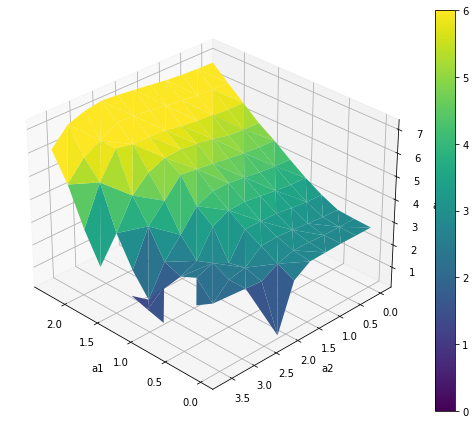

saved to ./data_output/AKLT3D_X10_scan_grid_critical_a3/surface_plot.png


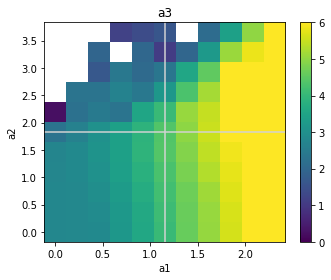

saved to ./data_output/AKLT3D_X10_scan_grid_critical_a3/image_plot.png


In [24]:
# %matplotlib widget
%matplotlib inline

def surface_plot_section(df,obs_name='a3',clim=None,filename=None):
    other_param_names=['a1','a2']
    fig = plt.figure(figsize=(8,6))
    ax=fig.add_subplot(111,projection='3d')
    df=df.sort_values(by=other_param_names)
    p=ax.plot_trisurf(df[other_param_names[0]],df[other_param_names[1]],df[obs_name],cmap='viridis',vmin=clim and clim[0],vmax=clim and clim[1])
    # p=ax.scatter(df[other_param_names[0]],df[other_param_names[1]],df[obs_name],c=df[obs_name],cmap='viridis',s=50,vmin=clim and clim[0],vmax=clim and clim[1])
    ax.set_xlabel(other_param_names[0]);ax.set_ylabel(other_param_names[1]);ax.set_zlabel(obs_name)
    # rotate camera 
    ax.view_init(30, 135)
    fig.colorbar(p)
    plt.tight_layout()
    plt.show()
    if filename:
        fig.savefig(filename,bbox_inches='tight');print(f'saved to {filename}')



def image_plot_2D(df,obs_name='a3',clim=None,filename=None):
    fig=plt.figure(figsize=(5,4))
    plt.axhline(critical_params['a2'],c='lightgrey')
    plt.axvline(critical_params['a1'],c='lightgrey')
    df=df.sort_values(by=['a1','a2'])
    a1s=np.unique(df['a1'])
    a2s=np.unique(df['a2'])
    obs=df[obs_name].values.reshape(len(a2s),len(a1s)).T
    def get_image_extent(xs,ys):
        return [xs[0]-(xs[1]-xs[0])/2,xs[-1]+(xs[1]-xs[0])/2,ys[0]-(ys[1]-ys[0])/2,ys[-1]+(ys[1]-ys[0])/2]
    plt.imshow(obs,origin='lower',extent=get_image_extent(a1s,a2s),aspect='auto',cmap='viridis',vmin=clim and clim[0],vmax=clim and clim[1])
    # plt.scatter(df['a1'],df['a2'],c=df[obs_name],s=50,vmin=clim and clim[0],vmax=clim and clim[1])
    plt.xlabel('a1');plt.ylabel('a2');plt.title(obs_name)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
    if filename:
        fig.savefig(filename,bbox_inches='tight');print(f'saved to {filename}')


surface_plot_section(df,'a3',clim=[0,6],filename='./data_output/{}/surface_plot.png'.format(task_name))
image_plot_2D(df,'a3',clim=[0,6],filename='./data_output/{}/image_plot.png'.format(task_name))

      fun: 52.710744689633025
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([-9.53674316e-07, -6.19888306e-06, -4.29153442e-06])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([ 2.19097465, -0.46855692,  3.29293665])


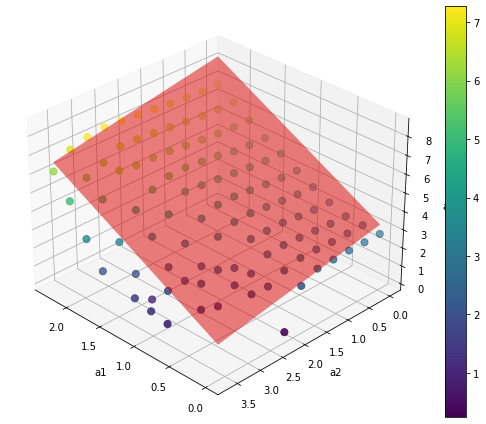

In [44]:
from scipy.optimize import minimize

# fit a3 with linear a1,a2 within tolerance
def fit_plane_with_tol(a1,a2,a3,tol=np.Infinity,initial_guess=None):
    def loss(params, a1,a2,a3):
        a,b,c=params
        residue=a1*a+b*a2+c-a3-1
        return np.sum(residue**2)
        return np.sum(np.where(np.abs(residue)<=tol,0.5*residue**2,tol*(np.abs(residue)-0.5*tol)))
    initial_guess=initial_guess or [1,1,1]
    res=minimize(loss,initial_guess,args=(a1,a2,a3))
    print(res)
    return res.x

initial_guess=[ 2.19097465, -0.46855692,  3.29293665]

params=fit_plane_with_tol(df['a1'],df['a2'],df['a3'],tol=100,initial_guess=initial_guess)

a1_min,a1_max=df['a1'].min(),df['a1'].max()
a2_min,a2_max=df['a2'].min(),df['a2'].max()
a1s=np.linspace(a1_min,a1_max,2)
a2s=np.linspace(a2_min,a2_max,2)
a1s,a2s=np.meshgrid(a1s,a2s)
a3s=params[0]*a1s+params[1]*a2s+params[2]

fig = plt.figure(figsize=(8,6))
ax=fig.add_subplot(111,projection='3d')

p=ax.scatter(df['a1'],df['a2'],df['a3'],c=df['a3'],cmap='viridis',s=50)

ax.plot_surface(a1s,a2s,a3s,alpha=0.5,color='red')

ax.set_xlabel('a1');ax.set_ylabel('a2');ax.set_zlabel('a3')
# rotate camera 

ax.view_init(30, 135)
fig.colorbar(p)
plt.tight_layout()
plt.show()